In [1]:
#
# Computing diffusion coeff and exponent alpha from individual msd
#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from os import listdir
import pickle
#from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import brunnermunzel, linregress
from sklearn.linear_model import LinearRegression

In [435]:
#
# read csv files
#

file_id = 'SK445-No3-2DG-6-2'

df = pd.read_csv(os.path.join('data', file_id + '.csv'))

dir_save = 'results_' + file_id
dir_save = dir_save.replace('-', '_')
print(dir_save)
os.makedirs(dir_save, exist_ok=True)
#print(df)
#print(df2)
#df['m0'] = df2['m0']
print(df)
n_traj = df['Trajectory'].max()
print('# of trajectories: ', n_traj)

results_SK445_No3_2DG_6_2
              Trajectory  Frame        x         y  z     m0     m1     m2  \
0          1           1      0  608.543    34.674  0  0.061  1.509  2.829   
1          2           1      1  606.534    37.174  0  0.049  1.590  3.119   
2          3           2      0  615.759    46.413  0  0.032  1.378  2.496   
3          4           2      1  614.724    45.839  0  0.036  1.460  2.755   
4          5           2      2  615.012    45.470  0  0.049  1.288  2.133   
...      ...         ...    ...      ...       ... ..    ...    ...    ...   
25396  25397        1411    100  774.755  1004.642  0  0.114  1.486  2.795   
25397  25398        1412     99   50.061  1008.267  0  0.055  1.337  2.365   
25398  25399        1412    100   50.992  1008.238  0  0.063  1.317  2.223   
25399  25400        1413     99  780.781  1010.602  0  0.037  1.409  2.512   
25400  25401        1413    100  780.705  1010.881  0  0.041  1.402  2.458   

          m3      m4  NPscore  
0    

0  th traj length =  2
1  th traj length =  4
2  th traj length =  13
3  th traj length =  101
4  th traj length =  18
5  th traj length =  73
6  th traj length =  12
7  th traj length =  96
8  th traj length =  101
9  th traj length =  101


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

0.0798428505815856


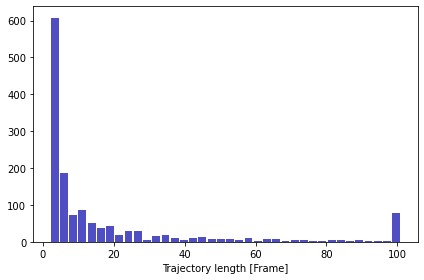

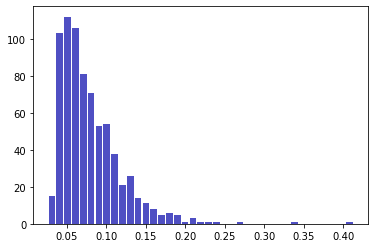

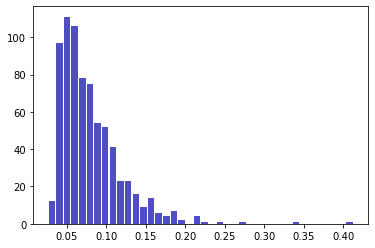

In [436]:
#
# basic characterization
#
lengths = []
m0s = []
for n in range(n_traj):
    df2 = df.loc[df['Trajectory'] == n+1]
    lengths.append(df2.shape[0])
    if n < 10:
        print(n, ' th traj length = ', df2.shape[0])
    if df2.shape[0] > 5:
        m0s.append(df2['m0'].mean())

lengths = np.array(lengths)
m0s = np.array(m0s)
print(np.mean(m0s))

fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=lengths, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Trajectory length [Frame]')
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'hist_traj_length.eps'))

fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=m0s, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=m0s[m0s[:] < 20000], bins=40, color='#0504aa', alpha=0.7, rwidth=0.85)

(73,) (73,)
(73, 2)


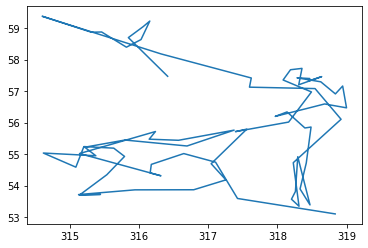

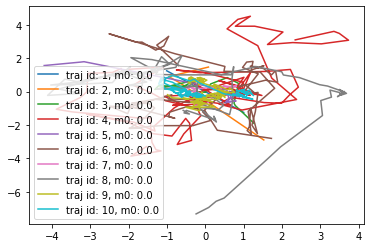

In [437]:
#
# data visualization
#
def select_single_trajectory(df, id_traj = 1, verbosity=1):
    df2 = df.loc[df['Trajectory'] == id_traj]
    #if id_cell == 1: print(df2)# for debug
    coord_x = df2['x'].to_numpy()
    coord_y = df2['y'].to_numpy()
    if verbosity == 1:
        print(coord_x.shape, coord_y.shape)
    return np.stack([coord_x, coord_y], axis=-1)

def compute_total_intensity(df, id_traj = 1):
    df2 = df.loc[df['Trajectory'] == id_traj]
    return df2['m0'].mean()

xy = select_single_trajectory(df, 6)
print(xy.shape)
fig, ax = plt.subplots()
plt.plot(xy[:, 0], xy[:, 1])

fig, ax = plt.subplots()
for n in range(10):
    xy = select_single_trajectory(df, n+1, verbosity=0)
    m0 = compute_total_intensity(df, n+1)
    mean_xy = np.mean(xy, axis=0)
    label = 'traj id: ' + str(n+1) + ', m0: ' + str(np.round(m0))
    plt.plot(xy[:, 0] - mean_xy[0], xy[:, 1] - mean_xy[1], label=label)
plt.legend()

len(msds) =  545


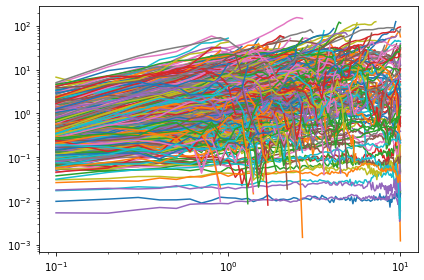

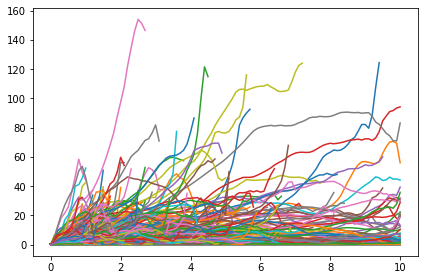

In [438]:
#
# MSD analysis
#
def naive_msd(r):
    shifts = np.arange(len(r))
    msd = np.zeros(shifts.size)

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None, :] - r[shift:, :]# if shift == 0, r[:None, :] not r[None, :]
        sqdist = np.square(diffs).sum(axis=1)
        msd[i] = sqdist.mean()

    return msd

msds = []
for n in range(n_traj):
    xy = select_single_trajectory(df, n+1, verbosity=0)
    if xy.shape[0] >= 10:
        #disp = (xy - xy[0, :])[1:]
        msd = naive_msd(xy)
        msds.append(msd)
print('len(msds) = ', len(msds))
num_msd = len(msds)

with open(os.path.join(dir_save, 'msds'), 'wb') as fp:
    pickle.dump(msds, fp)

fig, ax = plt.subplots()
for msd in msds:
    ts = 0.1 * np.arange(msd.shape[0])
    plt.loglog(ts[1:], msd[1:])
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'msds_log.eps'))

fig, ax = plt.subplots()
for msd in msds:
    ts = 0.1 * np.arange(msd.shape[0])
    plt.plot(ts, msd)
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'msds_normal.eps'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

0.041725425994065084
545


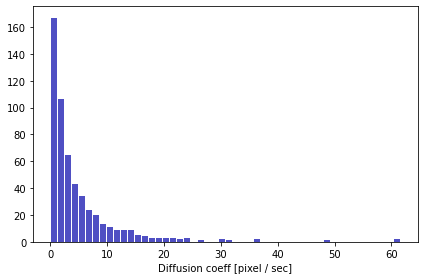

In [439]:
#
# individual diffusion coeffs assuming normal diffusion, following the protocol in (Delarue, Cell, 2018)
#
diffs = []
for msd in msds:
    msd_trunc = msd[:10]
    ts = 0.1 * np.arange(msd_trunc.shape[0])
    reg = LinearRegression(fit_intercept=False).fit(ts.reshape(-1, 1), msd_trunc)
    #print(reg.coef_)
    #res = linregress(ts, msd_trunc) # for comparison
    #print(res.slope)
    diffs.append(reg.coef_[0])

diffs = np.array(diffs)
fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=diffs, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Diffusion coeff [pixel / sec]')
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'hist_diff_coeff.eps'))

Deff = (diffs/4)*0.26*0.26 # Deff(pixel/sec)からDeff(um^2/sec)へ変換
print(np.median(Deff)) 
print(np.count_nonzero(Deff))

np.savetxt(os.path.join(dir_save, 'Deff.txt'), Deff)

     0         1         2         3         4         5          6    \
0    0.0  0.590835  1.086819  1.597341  2.052341  2.277016   2.611720   
1    0.0  0.661262  1.598614  2.482818  3.315752  4.204516   5.060884   
2    0.0  1.100437  2.443940  4.357785  4.973634  5.517333   6.039090   
3    0.0  0.619279  1.378961  2.205495  2.995772  3.805045   4.732524   
4    0.0  0.236427  0.563086  0.877274  1.036291  1.079000   1.021992   
..   ...       ...       ...       ...       ...       ...        ...   
540  0.0  1.257234  2.763407  4.119660  4.847510  4.185925   2.648368   
541  0.0  0.208655  0.337005  0.325536  0.328229  0.353435   0.417621   
542  0.0  0.274049  0.343240  0.308639  0.511344  0.608921   0.411975   
543  0.0  2.346601  5.798772  7.072390  8.266686  9.342633  12.722802   
544  0.0  0.802498  1.519345  2.582026  2.794906  3.800844   3.977201   

           7          8          9    ...       91         92        93   \
0     3.726405   4.359142   5.172251  ...      

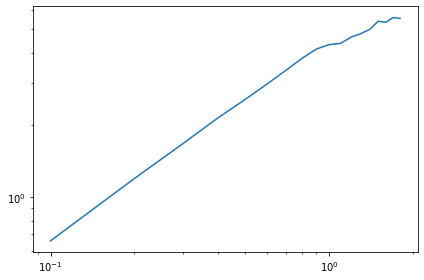

In [440]:
#
# Ensemble-averaged MSD
#
#for msd in msds:
#    print(msd.shape)
df_msds = pd.DataFrame(msds)
print(df_msds)
ens_msd = df_msds.mean(0, skipna=True).values
print(ens_msd)

fig, ax = plt.subplots()
ts = 0.1 * np.arange(ens_msd.shape[0])
plt.loglog(ts[1:19], ens_msd[1:19])
plt.tight_layout()
plt.savefig(os.path.join(dir_save, 'ens_msd_log.eps'))

res = linregress(np.log(ts[1:11]), np.log(ens_msd[1:11])) # for comparison
print(res, res.slope)

np.savetxt(os.path.join(dir_save, 'ens_msd.txt'), ens_msd)